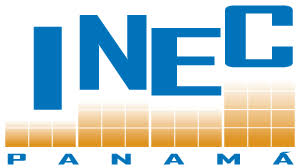

# ARIMA

Esta libreria construye la estimacion de los modelos ARIMA usando la metodologia especificada en el punto 2.1 del informe, mediante la metodología Box Jenkins.

Esta libreria realiza la estimacion, la proyeccion y la evaluación.


La expresión para un modelo ARMA(p,q):
$$y_t=c+\sum_{i=1}^p \alpha_i y_{t-i} + \epsilon_t+ \sum_{i=1}^q \beta_i \epsilon_{t-i}$$

Donde:

$y_t$: Serie modelada
$\epsilon_t$: Componente no predecible de la serie
$\alpha$: Parametros AR
$\beta$: Parametros MA

La estimación de estos modelos se realiza mediante Mínimos Cuadrados Ordinarios. Para la selección de los rezagos óptimos se usa la metodología de Box-Jenkins:

<ol> 
<li> Se elige el rezago óptimo (p,q) con el mejor criterio de información (AIC, BIC). Se estima el modelo. 
<li> Se observa la autocorrelación del error estimado. 
<li> Si se observa una autocorrelación significativa se agrega el rezago respectivo para corregirla. Se vuelve a estimar el modelo y se repite 2.
<li> El rezago óptimo es aquel que tienen el mejor criterio de información que elimina la autocorrelación en el error estimado.


### Librerias

In [1]:
#Importar librerias
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt

from ipynb.fs.defs.ConstruccionBasedeDatos import BasedeDatos

In [2]:
rutaOrigen = 'inputs/'
rutaDestino = 'resultados/'
rutaModelos = 'model_nowcast/'

### Construcción de Base de datos

In [3]:
bd_mensual_t,bd_trimestral_t,bd_anual_t,bd_all = BasedeDatos(rutaOrigen + 'bd_Panama.xlsx')

### Funciones ARIMA

In [4]:
#Funcion de seleccion de mejor modelo, estimacion y proyeccion out sample

def nowcast_arima(serie,train_size,out=1):
    # Se dividen los datos en 2 submuestras: "train" y "test"
    bd_train = serie[:train_size]
    bd_test =  serie[train_size+1:]
    
    # Se define un modelo base ARIMA(3,0,3)
    model = ARIMA(bd_train, order=(3,0,3))
    model_fit = model.fit([0]*7,disp = 0)
   
    # Se definen modelos alternativos ARIMA(i,0,j), donde para i y j se iteran los valores 0,1,2.
    for i in range(4):
        for j in range(4):
            model_aux = ARIMA(serie.dropna(), order=(i,0,j))
            model_fit_aux = model_aux.fit([0]*(i+j+1),disp=0)
            # Se compara el modelo base contra los modelos alternativos. Se selecciona el mejor modelo.
            # (model_fit_aux.bic < model_fit.bic) - Selecciona el mejor modelo en función del BIC
            # (sum(sm.tsa.stattools.acf(model_fit_aux.resid.dropna(), qstat = True, nlags= 4)[2] < 0.1) == 0) - Selecciona el modelo sin autocorrelacion
            if (model_fit_aux.bic < model_fit.bic) & (sum(sm.tsa.stattools.acf(model_fit_aux.resid.dropna(), qstat = True, nlags= 4)[2] < 0.1) == 0):
                model = model_aux
                model_fit = model_fit_aux
   
    # Se realizan las predicciones
    predict = model_fit.predict(start = train_size-1, end = train_size + out)

    
    return predict

def eval_arima(serie):
    
    #Base de proyecciones
    prj_pib = pd.DataFrame()

    #Realiza la predicción fuera de muestra
    
    for train_size in range(int(len(serie)*2/3),len(serie)):

        prj_pib = pd.concat([prj_pib,nowcast_arima(serie,train_size)[1:2]], axis = 0)
        
    prj_pib = pd.concat([prj_pib,serie],axis=1)
    
    prj_pib.columns = ['EVAL_ARIMA','PIB_A']
    
    return prj_pib

################################################################


### Proyección ARIMA

###### Serie  proyectar

Vivienda, Agua, Electricidad y Gas: ipc1_viv\
Transporte: ipc1_trp\
Comercio - Importaciones: imae_com_imp_vl\
Venta de Autos: imae_com_car\
Indice Mensual de Actividad Económica: imae\
Ingreso por peaje Panamax: imae_trn_pea_pn\
Concreto premezclado: imae_man_con\
Movimiento de Contenedores: imae_trn_mct\
Ingreso por peaje Panamax: imae_trn_pea_pn\
Venta de Combustible: imae_com_cmb_in


In [5]:
serie = bd_all['imae_trn_pea_pn_Mensual_VariacionAnual'].dropna()

In [6]:
#Definiendo frecuencia automaticamente
serie.index = pd.DatetimeIndex(serie.index.values,
                               freq=serie.index.inferred_freq)

###### Proyecciones usando la funcion nowcast_arima

C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


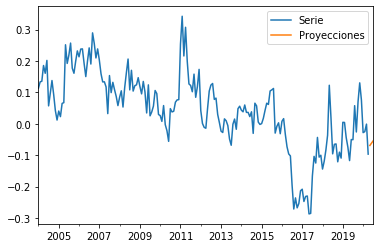

In [7]:
baseARIMA = pd.DataFrame()

#Base de proyecciones

baseARIMA.loc[:,'Serie'] = serie 
baseARIMA = baseARIMA.join(pd.DataFrame(nowcast_arima(serie,len(serie)+1),columns = ['Proyecciones']),how = 'outer')

baseARIMA.plot()
    
plt.show()

In [8]:
with pd.ExcelWriter(rutaDestino + 'baseARIMA.xlsx') as writer:
    baseARIMA.to_excel(writer, sheet_name='Proyecciones ARIMA')

### Evaluación de Proyecciones

###### Proyecciones condicionales

In [9]:
eval_arima = eval_arima(serie)

C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:492: HessianInversionWarning

C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\eo\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Max

###### Base de datos de proyecciones

In [10]:
eval_arima

,EVAL_ARIMA,PIB_A
2004-01-01,NaN,0.113621
2004-02-01,NaN,0.133492
2004-03-01,NaN,0.135616
2004-04-01,NaN,0.185614
2004-05-01,NaN,0.160859
...,...,...
2019-12-01,0.109845,0.075871
2020-01-01,0.079856,-0.028087
2020-02-01,-0.003001,-0.024849
2020-03-01,-0.016038,-0.000998


###### Gráfico de proyecciones

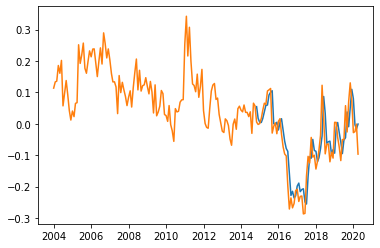

In [11]:
plt.plot(eval_arima)

In [12]:
with pd.ExcelWriter(rutaDestino + 'evalARIMA.xlsx') as writer:
    eval_arima.to_excel(writer, sheet_name='Proyecciones ARIMA')